調理手順

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

データセットのダウンロード

In [7]:
data_folder='numberdata/'
BATCH_SIZE=8
     

mnist_data = MNIST(data_folder, train=True, download=True, transform=transforms.ToTensor())
#
data_loader = DataLoader(mnist_data,batch_size=BATCH_SIZE,shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5352564.29it/s]


Extracting numberdata/MNIST\raw\train-images-idx3-ubyte.gz to numberdata/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 224361.51it/s]


Extracting numberdata/MNIST\raw\train-labels-idx1-ubyte.gz to numberdata/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1457579.86it/s]


Extracting numberdata/MNIST\raw\t10k-images-idx3-ubyte.gz to numberdata/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4564094.10it/s]

Extracting numberdata/MNIST\raw\t10k-labels-idx1-ubyte.gz to numberdata/MNIST\raw



データの中身を見てみる

In [9]:
data_iterator = iter(data_loader)
images, labels = next(data_iterator)
     

print(len(images))
print(len(labels))

8
8


データを可視化してみる

(1, 28, 28)


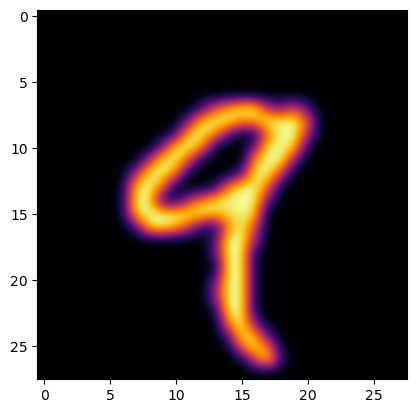

ラベル: tensor(9)


In [10]:
# 何番目の画像を表示しますか
location=4
# numpy行列に変換した上、dataに代入します
data = images[location].numpy()
print(data.shape)
# matplotlibが描画するためにデータチャンネル調整します
reshaped_data=data.reshape(28,28)
# データから画像を描画します
plt.imshow(reshaped_data, cmap='inferno', interpolation='bicubic')
plt.show()
print('ラベル:', labels[location])

学習データと検証データを用意する

In [11]:
# 学習データ
train_data_with_labels = MNIST(data_folder, train=True, download=True, transform=transforms.ToTensor())
train_data_loader = DataLoader(train_data_with_labels,batch_size=BATCH_SIZE,shuffle=True)

# 検証データ
test_data_with_labels = MNIST(data_folder, train=False, download=True, transform=transforms.ToTensor())
test_data_loader = DataLoader(test_data_with_labels,batch_size=BATCH_SIZE,shuffle=True)

ニューラルネットワークの定義

In [12]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    # 入力層
    self.layer1 = nn.Linear(28 * 28, 100)
    # 中間層（隠れ層）
    self.layer2 = nn.Linear(100, 50)
    # 出力層
    self.layer3 = nn.Linear(50,10)
        
  def forward(self, input_data):
    input_data = input_data.view(-1, 28 * 28)
    input_data = self.layer1(input_data)
    input_data = self.layer2(input_data)
    input_data = self.layer3(input_data)
    return input_data

モデル

In [13]:
model=MLP()

コスト関数と最適化手法を定義する

In [14]:
import torch.optim as optimizer

# ソフトマックスロスエントロピー
lossResult = nn.CrossEntropyLoss()
# SGD
optimizer = optimizer.SGD(model.parameters(), lr=0.01)

学習

In [16]:
# 最大学習回数
MAX_EPOCH=4

for epoch in range(MAX_EPOCH):
  total_loss = 0.0
  for i, data in enumerate(train_data_loader):
    
    # dataから学習対象データと教師ラベルデータを取り出します
    train_data, teacher_labels = data
    
    # 入力をtorch.autograd.Variableに変換します
    train_data, teacher_labels = Variable(train_data), Variable(teacher_labels)
    
    # 計算された勾配情報を削除します
    optimizer.zero_grad()
    
    # モデルに学習データを与えて予測を計算します
    outputs = model(train_data)
    
    # lossとwによる微分計算します
    loss = lossResult(outputs, teacher_labels)
    loss.backward()
    
    # 勾配を更新します
    optimizer.step()
    
    # 誤差を累計します
    total_loss += loss.data.item()
    
    # 2000ミニバッチずつ、進捗を表示します 
    if i % 2000 == 1999:
      print('学習進捗：[%d, %d] 学習誤差(loss): %.3f' % (epoch + 1, i + 1, total_loss / 2000))
      total_loss = 0.0
        
print('学習終了')

学習進捗：[1, 2000] 学習誤差(loss): 0.842
学習進捗：[1, 4000] 学習誤差(loss): 0.381
学習進捗：[1, 6000] 学習誤差(loss): 0.331
学習進捗：[2, 2000] 学習誤差(loss): 0.304
学習進捗：[2, 4000] 学習誤差(loss): 0.312
学習進捗：[2, 6000] 学習誤差(loss): 0.317
学習進捗：[3, 2000] 学習誤差(loss): 0.295
学習進捗：[3, 4000] 学習誤差(loss): 0.292
学習進捗：[3, 6000] 学習誤差(loss): 0.296
学習進捗：[4, 2000] 学習誤差(loss): 0.268
学習進捗：[4, 4000] 学習誤差(loss): 0.284
学習進捗：[4, 6000] 学習誤差(loss): 0.313
学習終了


検証

In [17]:
import torch
# トータル
total = 0
# 正解カウンター
count_when_correct = 0

#
for data in test_data_loader:
  # 検証データローダーからデータを取り出した上、アンパックします
  test_data, teacher_labels = data
  # テストデータを変換した上、モデルに渡して、判定してもらいます
  results = model(Variable(test_data))
  # 予測を取り出します
  _, predicted = torch.max(results.data, 1)
  #
  total += teacher_labels.size(0)
  count_when_correct += (predicted == teacher_labels).sum()

    
print('count_when_correct:%d'%(count_when_correct))
print('total:%d'%(total))

print('正解率：%d / %d = %f'% (count_when_correct, total, int(count_when_correct)/int(total)))

count_when_correct:9219
total:10000
正解率：9219 / 10000 = 0.921900


個別データで検証

ラベル： tensor(1)


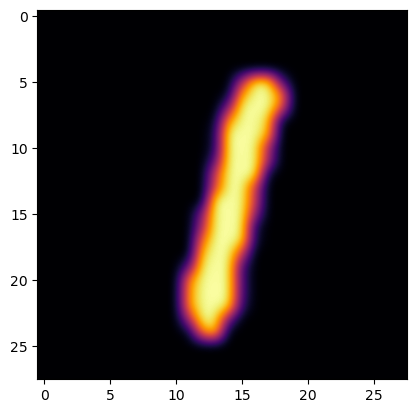

In [24]:
test_iterator = iter(test_data_loader)
# ここで回数を増減して、違うテストデータを取り出せます
test_data, teacher_labels = next(test_iterator)
# テストデータを変換した上、モデルに渡して、判定してもらいます
results = model(Variable(test_data))
_, predicted_label = torch.max(results.data, 1)

location=1
plt.imshow(test_data[location].numpy().reshape(28, 28), cmap='inferno', interpolation='bicubic')
print('ラベル：', predicted_label[location])